# Capstone Project Submission

* Student name: Carrie Liu
* Student pace: self paced
* Scheduled project review date/time: May 6, 2022 / 10:00 AM
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Predicting the Market Value of FIFA Soccer Players

## Overview


Every year, EA sports will reveal its FIFA ratings for each soccer player. From sprint speed to finishing, passing accuracy to stamina, they meticulously watch what happens on the pitch to assess, judge, and evaluate players across more than 30 attributes that define a player’s skill level. Their assessments come together to create the FIFA Ratings – the authoritative ranking of over 17,000 players’ footballing ability. And more importantly, the dataset will also provide the market value and wages for each player. 

As a soccer fan, I am very excited for the rating release every year and have a strong interest in understanding what factors determine the market value of soccer players. According to FIFA's description of its' [Ratings Collective](https://www.ea.com/games/fifa/fifa-22/ratings), the overall ratings are based on the attributes. Therefore, for this project, we will focus on the prediction of players' market value using these attributes.

We will leverage the **data source** [Kaggle FIFA 22 complete player dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset), which covers the players data (with 100+ attributes) for the Career Mode from FIFA 15 to FIFA 22, and allows multiple comparisons for the same players across the last 8 version of the videogame. We will focus on the FIFA 2022 data sets.

Our **objective** is to build a regression model to understand what key factors determine the market value of soccer players by what amount. 

Our **approach** will build a regression model by incorporating random forest into it to get the best prediction of players' market value. 

## I. Import Packages and Load Data

### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
plt.style.use('seaborn')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [5]:
raw_data = pd.read_csv('Data/players_22.csv')

In [6]:
raw_data.shape

(19239, 110)

In [7]:
columns_to_drop = ['sofifa_id','player_url','short_name','long_name','overall', 'potential','dob','club_name',
                   'league_name','club_team_id','club_jersey_number','club_loaned_from','nationality_id',
                   'nation_position','nation_jersey_number','real_face','player_tags','player_traits',
                  'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm',
                  'lwb', 'ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk',
                  'player_face_url','club_logo_url','club_flag_url','nation_logo_url','nation_flag_url']

In [8]:
raw_data = raw_data.drop(columns_to_drop, axis=1)

In [9]:
print(raw_data.shape)
raw_data.head()

(19239, 60)


,player_positions,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_position,club_joined,club_contract_valid_until,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,"RW, ST, CF",78000000.0,320000.0,34,170,72,1.0,RW,2021-08-10,2023.0,...,96,20,35,24,6,11,15,14,8,NaN
1,ST,119500000.0,270000.0,32,185,81,1.0,ST,2014-07-01,2023.0,...,88,35,42,19,15,6,12,8,10,NaN
2,"ST, LW",45000000.0,270000.0,36,187,83,1.0,ST,2021-08-27,2023.0,...,95,24,32,24,7,11,15,14,11,NaN
3,"LW, CAM",129000000.0,270000.0,29,175,68,1.0,LW,2017-08-03,2025.0,...,93,35,32,29,9,9,15,15,11,NaN
4,"CM, CAM",125500000.0,350000.0,30,181,70,1.0,RCM,2015-08-30,2025.0,...,89,68,65,53,15,13,5,10,13,NaN


## II. Exploratory Data Analysis

### 1. Data cleaning

#### Check missing data

In [10]:
raw_data.isna().sum()

player_positions                   0
value_eur                         74
wage_eur                          61
age                                0
height_cm                          0
weight_kg                          0
league_level                      61
club_position                     61
club_joined                     1163
club_contract_valid_until         61
nationality_name                   0
nation_team_id                 18480
preferred_foot                     0
weak_foot                          0
skill_moves                        0
international_reputation           0
work_rate                          0
body_type                          0
release_clause_eur              1176
pace                            2132
shooting                        2132
passing                         2132
dribbling                       2132
defending                       2132
physic                          2132
attacking_crossing                 0
attacking_finishing                0
a

In [11]:
raw_data = raw_data.dropna(subset=['value_eur', 'club_joined'])

In [12]:
raw_data = raw_data.fillna(0)

#### Check data types

In [13]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18063 entries, 0 to 19238
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             18063 non-null  object 
 1   value_eur                    18063 non-null  float64
 2   wage_eur                     18063 non-null  float64
 3   age                          18063 non-null  int64  
 4   height_cm                    18063 non-null  int64  
 5   weight_kg                    18063 non-null  int64  
 6   league_level                 18063 non-null  float64
 7   club_position                18063 non-null  object 
 8   club_joined                  18063 non-null  object 
 9   club_contract_valid_until    18063 non-null  float64
 10  nationality_name             18063 non-null  object 
 11  nation_team_id               18063 non-null  float64
 12  preferred_foot               18063 non-null  object 
 13  weak_foot       

#### Focus on the players of level 1 league

In [14]:
raw_data.groupby('league_level').count()

,player_positions,value_eur,wage_eur,age,height_cm,weight_kg,club_position,club_joined,club_contract_valid_until,nationality_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
league_level,,,,,,,,,,,,,,,,,,,,,
1.0,14114,14114,14114,14114,14114,14114,14114,14114,14114,14114,...,14114,14114,14114,14114,14114,14114,14114,14114,14114,14114
2.0,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,...,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318
3.0,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,...,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
4.0,542,542,542,542,542,542,542,542,542,542,...,542,542,542,542,542,542,542,542,542,542
5.0,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27


In [15]:
data = raw_data[raw_data.league_level == 1.0]

In [16]:
data = data.drop(['league_level'], axis=1)

#### Convert player_position into number of player_positions

In [17]:
data['count_player_positions'] = data['player_positions'].str.count(',') + 1

#### Convert club_joined and club_contract_valid_until into number of years with and left with club

In [18]:
data['year_with_club'] = 2022 - pd.DatetimeIndex(data['club_joined']).year

In [19]:
data['year_left_with_club'] = data['club_contract_valid_until'] - 2022 + 1

In [20]:
data = data.drop(['club_joined', 'club_contract_valid_until'], axis=1)

#### Convert nation_team_id into 0 and 1 to symbolize whether the players are in naiton teams

In [21]:
data['nation_team'] = data['nation_team_id'].astype(bool).astype(int)

#### Convert preferred_foot into 0 and 1 to symbolize if preferred foot is Right than 1

In [22]:
data['preferred_foot_right'] = data['preferred_foot'] == 'Right'

In [23]:
data['preferred_foot_right'] = data['preferred_foot_right'].astype(int)

#### Convert categorical features into numbers
One-hot Encoding on club_position, nationality_name, work_rate and body_type

In [24]:
one_hot_club_position = pd.get_dummies(data['club_position'], prefix = 'club_position')
one_hot_club_position.drop('club_position_CF', axis=1, inplace=True)

In [25]:
one_hot_nationality = pd.get_dummies(data['nationality_name'], prefix = 'natiionality', drop_first = True)

In [26]:
one_hot_work_rate = pd.get_dummies(data['work_rate'], prefix = 'work_rate')
one_hot_work_rate.drop('work_rate_Low/Low', axis=1, inplace=True)

In [27]:
one_hot_body_type = pd.get_dummies(data['body_type'], prefix = 'body_type')
one_hot_body_type.drop('body_type_Stocky (170-)', axis=1, inplace=True)

In [28]:
df = pd.concat([data, one_hot_club_position, one_hot_nationality, one_hot_work_rate, one_hot_body_type], axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14114 entries, 0 to 19238
Columns: 263 entries, player_positions to body_type_Unique
dtypes: float64(12), int64(44), object(6), uint8(201)
memory usage: 9.5+ MB


### 2. Attributes analysis

#### Target: Value

In [30]:
df['value_eur_mil'] = df['value_eur'] / 1000000

In [31]:
df['value_eur_mil'].describe()

count    14114.000000
mean         3.320938
std          8.663977
min          0.009000
25%          0.475000
50%          1.000000
75%          2.300000
max        194.000000
Name: value_eur_mil, dtype: float64

#### Value vs Weekly Wage

<AxesSubplot:xlabel='wage_eur', ylabel='value_eur_mil'>

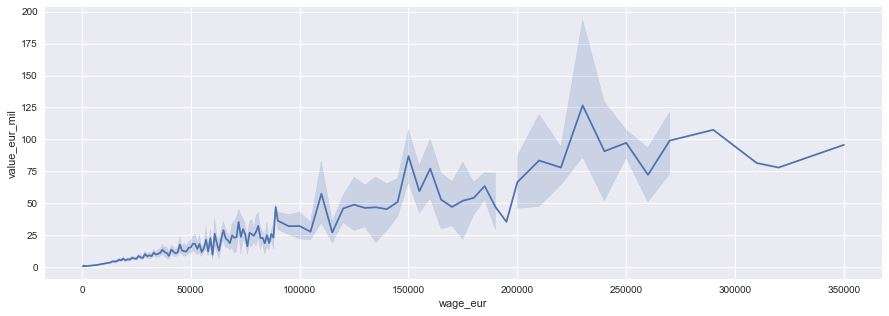

In [32]:
plt.figure(figsize=(15,5))
sns.lineplot(x='wage_eur', y='value_eur_mil', data=df)

Findings: There's linearity between value and weekly wages. The higher the weekly wage of the player, the higher market value of the player. 

#### Value vs Age

<AxesSubplot:xlabel='age', ylabel='value_eur_mil'>

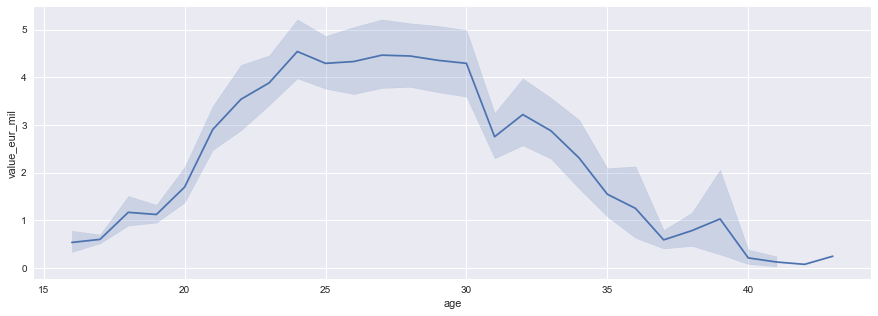

In [33]:
plt.figure(figsize=(15,5))
sns.lineplot(x='age', y='value_eur_mil', data=df)

Findings: There's linearity between value and age with age 30 as a cutoff.

#### Value vs Height and Weight

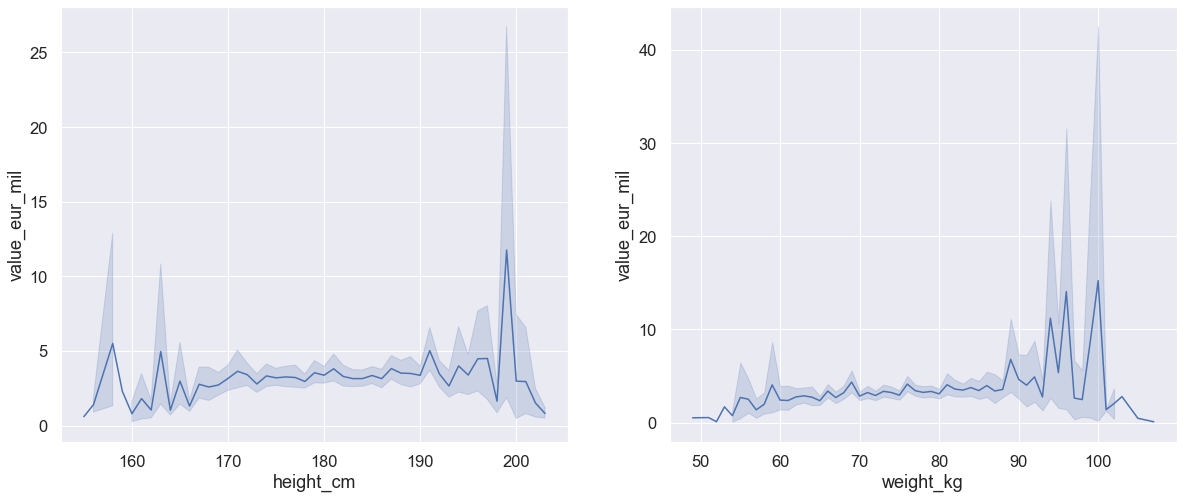

In [34]:
fig = plt.figure(figsize=(20,8))
sns.set(font_scale=1.5)

ax1 = fig.add_subplot(121)
ax1 = sns.lineplot(x='height_cm', y='value_eur_mil', data=df, palette = 'mako')

ax2 = fig.add_subplot(122)
ax2 = sns.lineplot(x='weight_kg', y='value_eur_mil', data=df, palette = 'rocket')

#### Value vs Time with Club

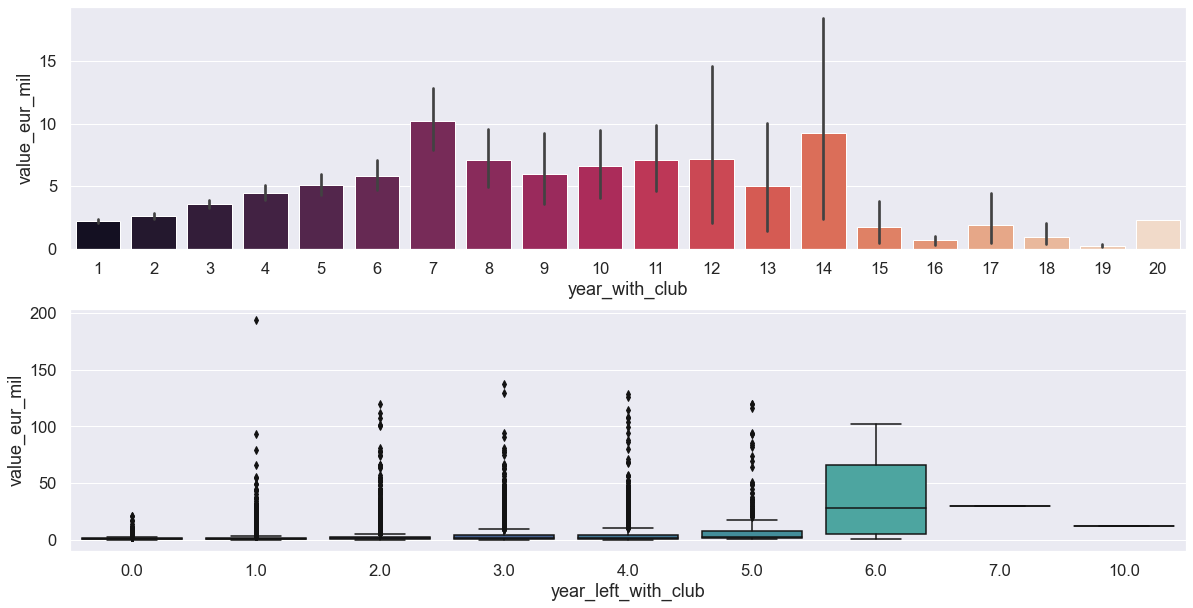

In [48]:
fig = plt.figure(figsize=(20,10))
fig.tight_layout() 
plt.subplots_adjust(hspace = 0.25)

ax1 = fig.add_subplot(211)
ax1 = sns.barplot(x='year_with_club', y='value_eur_mil', data=df, palette = 'rocket')

ax2 = fig.add_subplot(212)
ax2 = sns.boxplot(x='year_left_with_club', y='value_eur_mil', data=df, palette = 'mako')

#### Value vs Whether the players play in nation team

In [42]:
df['nation_team'].value_counts(normalize = True)

0    0.95671
1    0.04329
Name: nation_team, dtype: float64

<AxesSubplot:xlabel='nation_team', ylabel='value_eur_mil'>

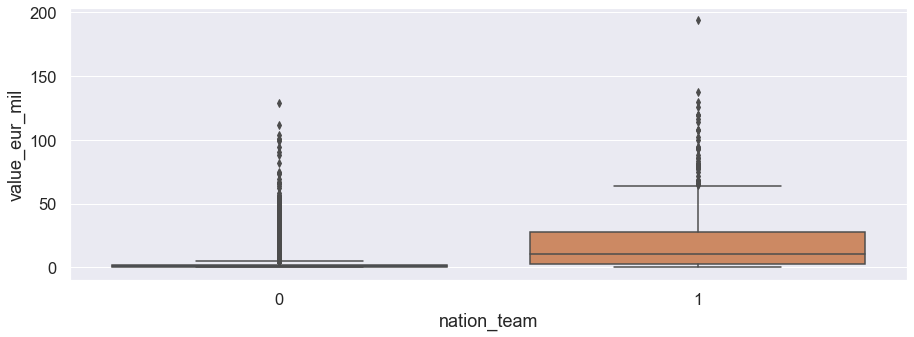

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x='nation_team', y='value_eur_mil', data=df)

Findings: only 4.3% of the players in the list are playing in their nation team. There's a lineary between value and nation team player. We also noticed that players who play in nation team have higher market value compared to those who do not play in nation team.

#### Value vs Player Position

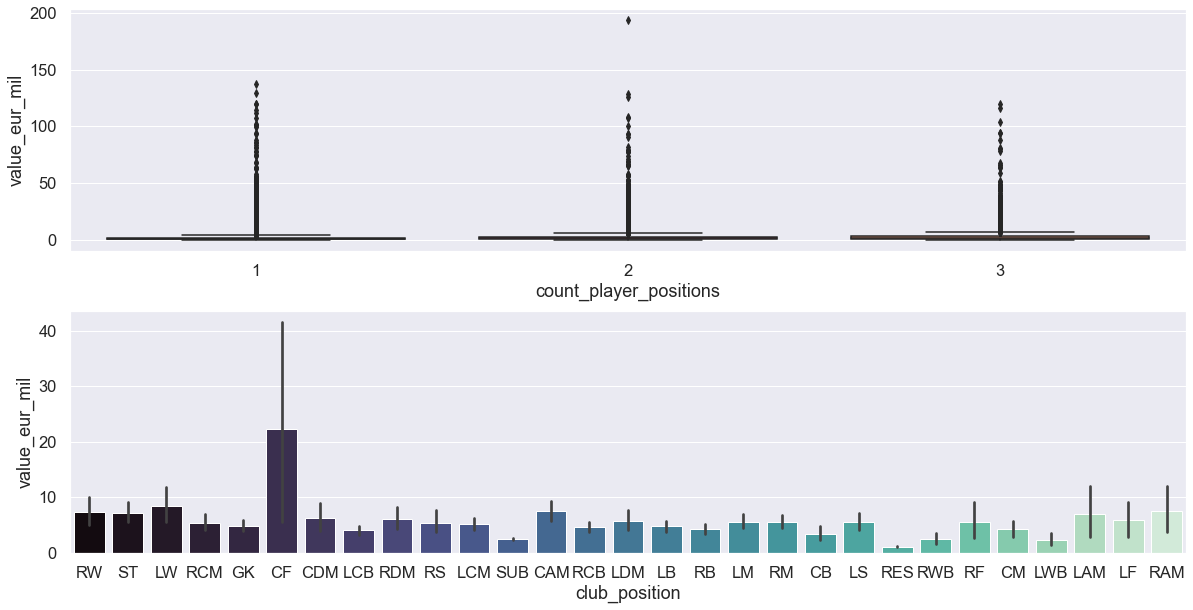

In [55]:
fig = plt.figure(figsize=(20,10))
fig.tight_layout() 
plt.subplots_adjust(hspace = 0.25)

ax1 = fig.add_subplot(211)
ax1 = sns.boxplot(x='count_player_positions', y='value_eur_mil', data=df, palette = 'rocket')

ax2 = fig.add_subplot(212)
ax2 = sns.barplot(x='club_position', y='value_eur_mil', data=df, palette = 'mako')

#### Value vs Preferred Foot

In [56]:
df['preferred_foot'].value_counts(normalize = True)

Right    0.764135
Left     0.235865
Name: preferred_foot, dtype: float64

<AxesSubplot:xlabel='preferred_foot', ylabel='value_eur_mil'>

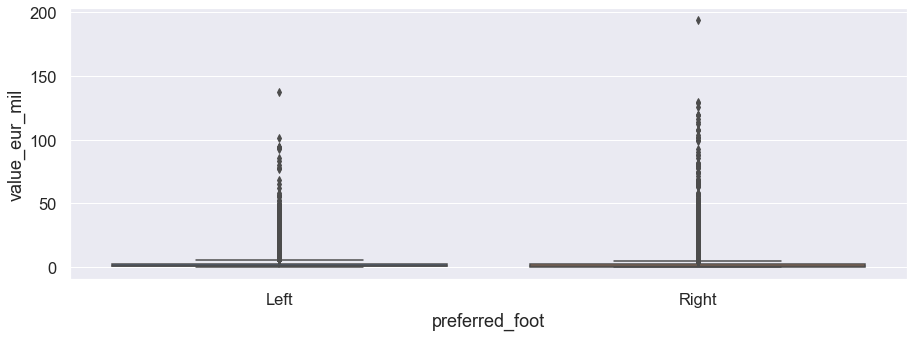

In [57]:
plt.figure(figsize=(15,5))
sns.boxplot(x='preferred_foot', y='value_eur_mil', data=df)

#### Value vs Body Type

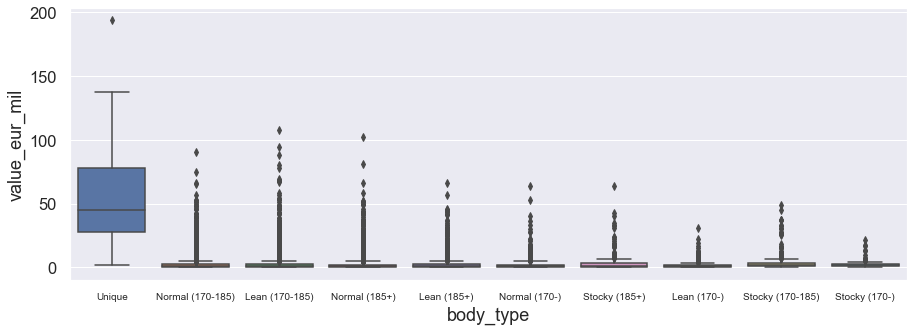

In [71]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='body_type', y='value_eur_mil', data=df)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10);

#### Value vs Work Rate

What are work rates? Work Rates dictate where players position themselves on the pitch. It is the rate of a player’s behavior on the pitch in terms of attacking and defensive works. The Work Rate is defined for Attacking (Attacking Work Rate – Abbreviated as AWR) and Defensive (Defensive Work Rate – Abbreviated as DWR) and rated between low, medium, and high, which defines how a player puts effort into participates in attacks and defenses even when they are out of position.

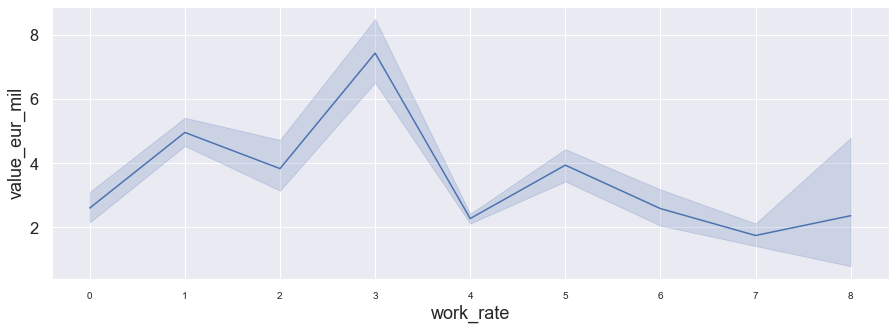

In [86]:
plt.figure(figsize=(15,5))
ax=sns.lineplot(x='work_rate', y='value_eur_mil', data=df)
ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 10);